In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, precision_recall_curve,
                             roc_curve, classification_report, confusion_matrix)
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
base_path = '/content/drive/MyDrive/hci-credit'

df_train = pd.read_csv(base_path + '/application_train.csv')
df_bureau = pd.read_csv(base_path + '/bureau.csv')

In [13]:
def engineer_features(df):
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['LOAN_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['GOODS_LOAN_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

    df['EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

    df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

df_train = engineer_features(df_train)

bureau_agg = df_bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'CNT_CREDIT_PROLONG': ['sum']
})

bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
df_train = df_train.merge(bureau_agg, on='SK_ID_CURR', how='left')

In [14]:
cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object']
df_train = pd.get_dummies(df_train, columns=cat_cols, dummy_na=True)

df_train = df_train.replace([np.inf, -np.inf], np.nan)

imputer = SimpleImputer(strategy='median')
y = df_train['TARGET']
X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])

X_imputed = pd.DataFrame(imputer.fit_transform(X))
X_imputed.columns = X.columns

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=8,
    min_child_weight=4,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=ratio,
    seed=42,
    early_stopping_rounds=100,
    eval_metric='auc'
)


eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train, eval_set=eval_set, verbose=200)

[0]	validation_0-auc:0.74982	validation_1-auc:0.71686
[200]	validation_0-auc:0.84611	validation_1-auc:0.76469
[400]	validation_0-auc:0.87997	validation_1-auc:0.76948
[600]	validation_0-auc:0.90508	validation_1-auc:0.77031
[753]	validation_0-auc:0.92072	validation_1-auc:0.77030


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=None, nthread=4, ...)

ROC AUC Score: 0.7704

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     56538
           1       0.20      0.60      0.30      4965

    accuracy                           0.77     61503
   macro avg       0.58      0.69      0.58     61503
weighted avg       0.90      0.77      0.82     61503



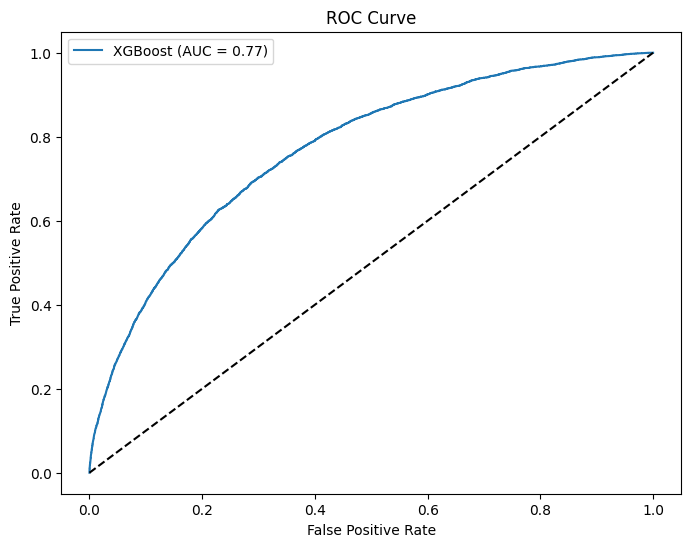

In [19]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.title('SHAP Value Summary Plot')
plt.tight_layout()
plt.show()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.title('SHAP Value Summary Plot')
plt.tight_layout()
plt.show()